In [19]:
import torch
import pandas as pd
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from pipetorch.train import *


In [20]:
#Checking wich GPU is beeing used

!nvidia-smi

Fri Oct 29 14:14:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 470.63.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:05:00.0 Off |                  N/A |
| 29%   27C    P8    18W / 250W |   2287MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:09:00.0 Off |                  N/A |
| 29%   

In [22]:
# set data directory
#data_dir = 'dialogue/Bjärn/images/splitfolders/' #Spectograms
data_dir = 'dialogue/Olaf/images/mfcc/splitfolders/' #MFCC

#preparing the transform method to transform data into a Tensor object
transform = transforms.Compose([
    #transforms.RandomRotation(20),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor()]) 
    
train_set = datasets.ImageFolder(data_dir + 'train', transform=transform) #contents from the 'train' folder is put in train_set
test_set = datasets.ImageFolder(data_dir + 'test', transform=transform)
print(len(train_set))
print(len(test_set))
print(len(test_set)/len(test_set+train_set))
train_dataloader = DataLoader(train_set, batch_size=32, shuffle=True)#train_set is made into a dataloader, shuffled
test_dataloader = DataLoader(test_set, batch_size=32, shuffle=True)

1813
228
0.11170994610485056


In [23]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten() #the images are flattened (pixels are placed end to end)
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(373248, 512), # in the first layer, 373248 is the amount of input features, 512 is the output amount
            nn.ReLU(),
            nn.Linear(512, 512), #second layer, input and output features is 512 (maybe this could be larger?)
            nn.ReLU(),
            nn.Linear(512, 10) #output layer, input features is 512, output features is 10 (these 10 is what the NN uses to 'learn')
        )

    def forward(self, x): #this function runs the above code with our data 'x' passed to it
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

    def post_forward(self, y): 
        return torch.argmax(y, axis=1) #returns the highest value from a tensor object (jeroen wrote this function)
    
model = NeuralNetwork().to(device) #model is passed to gpu
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=373248, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [24]:
loss_fn = nn.CrossEntropyLoss() #loss function is defined (we should try different ones, jeroen mentioned MSELoss and BCELoss)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3) #the optimizer is defined

In [25]:
def train(dataloader, model, loss_fn, optimizer): #function for training the NN
    size = len(train_dataloader)
    model.train()
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [26]:
def test(dataloader, model, loss_fn): #function for testing
    size = len(test_dataloader)
    num_batches = len(test_dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [7]:
#epochs = 5
#for t in range(epochs):
#    print(f"Epoch {t+1}\n-------------------------------")
#    train(train_dataloader, model, loss_fn, optimizer)
#    test(test_dataloader, model, loss_fn)
#print("Done!")

In [27]:
model = NeuralNetwork()

In [36]:
t = trainer(model, loss_fn, train_dataloader, test_dataloader, gpu=0, metrics=accuracy_score) #NN is passed to t with parameters

In [37]:
t.train(50, (1e-5, 1e-4))

Total:   0%|          | 0/104000 [00:00<?, ?it/s]

 1 12.46s trainloss=0.85479 validloss=0.76077 accuracy_score=0.75877 
 2 11.41s trainloss=0.71868 validloss=0.66813 accuracy_score=0.80702 
 3 13.02s trainloss=0.78225 validloss=0.71131 accuracy_score=0.74561 
 4 13.30s trainloss=0.82115 validloss=0.66350 accuracy_score=0.81579 
 5 11.72s trainloss=0.67239 validloss=0.64800 accuracy_score=0.80702 
 6 12.18s trainloss=0.61357 validloss=0.59289 accuracy_score=0.83772 
 7 12.54s trainloss=0.62410 validloss=0.55923 accuracy_score=0.79386 
 8 14.24s trainloss=0.56662 validloss=0.53814 accuracy_score=0.82456 
 9 12.75s trainloss=0.63036 validloss=0.57107 accuracy_score=0.82456 
10 11.88s trainloss=0.56918 validloss=0.49332 accuracy_score=0.84649 
11 11.62s trainloss=0.56215 validloss=0.51955 accuracy_score=0.81579 
12 11.63s trainloss=0.54465 validloss=0.49570 accuracy_score=0.78947 
13 11.58s trainloss=0.61209 validloss=0.56476 accuracy_score=0.79386 
14 11.82s trainloss=0.57876 validloss=0.47251 accuracy_score=0.83772 
15 11.48s trainloss=

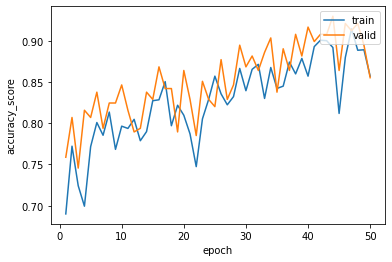

In [38]:
t.validation_curve()

In [39]:
t.evaluator

    accuracy_score  epoch      loss  phase
0         0.690017    1.0  0.854794  train
1         0.758772    1.0  0.760769  valid
2         0.772201    2.0  0.718681  train
3         0.807018    2.0  0.668131  valid
4         0.724214    3.0  0.782250  train
..             ...    ...       ...    ...
95        0.921053   48.0  0.264005  valid
96        0.889134   49.0  0.296752  train
97        0.894737   49.0  0.301284  valid
98        0.857143   50.0  0.397961  train
99        0.855263   50.0  0.381682  valid

[100 rows x 4 columns]